In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import bambi as bmb 
import hssm
import os
import arviz as az 
import pymc as pm 
from utils import *
hssm.set_floatX("float32")
random_seed = 10

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [3]:
files = os.listdir('data/')
comb_data = pd.concat([extract_data(fname) for fname in files]).reset_index(drop=True)


In [4]:
comb_data['bumps_'] = '0_noisy'
comb_data.loc[comb_data['bumps'] == 'single', 'bumps_'] = '1_single'
comb_data.loc[comb_data['bumps'] == 'center', 'bumps_'] = '1_center'


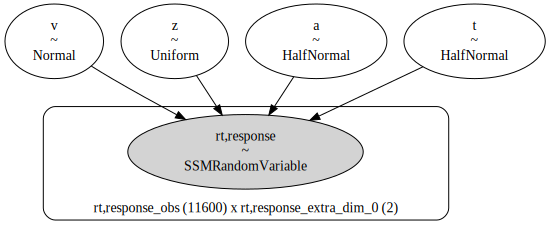

In [41]:
model_default = hssm.HSSM(data=comb_data[['participant', 'rt', 'response']])
model_default.graph()

In [5]:
hssm_model = hssm.HSSM(data=comb_data[['participant', 'rt', 'response', 'means', 'direction', 'bumps_', 'diff_dir', 'difference']], 
            include=
            [{"name": "v",
              "formula": "v ~ C(direction) + C(bumps_) + C(diff_dir)"},
              {"name": "t", 
               "formula" : "t ~ (1|participant)"},
              {"name": "a",
               "formula": "a ~ difference"},
              {"name": "z",
              "formula": "z ~ C(direction)"
              }

              ])

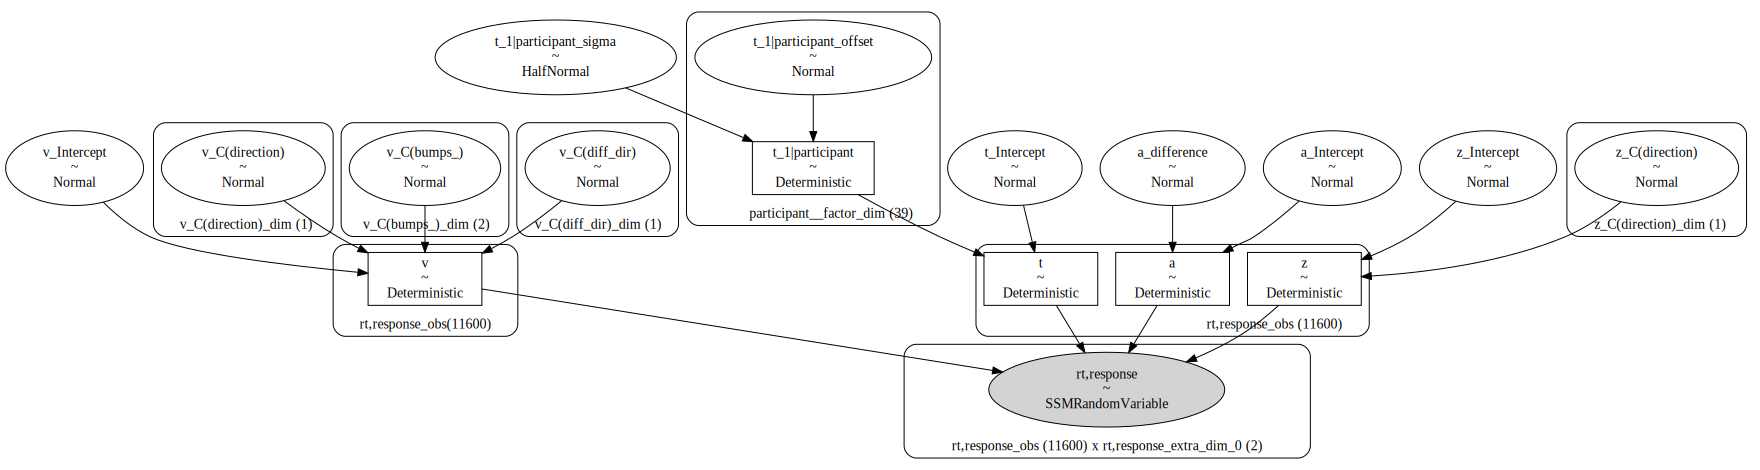

In [6]:
hssm_model.graph()

In [8]:
sample = hssm_model.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_Intercept, v_C(direction), v_C(bumps_), v_C(diff_dir), a_Intercept, a_difference, z_Intercept, z_C(direction), t_Intercept, t_1|participant_sigma, t_1|participant_offset]
